# Understanding the KC-MBON syanpse structure and its postsynaptic specificity

### Import neccesary library modules now

In [1]:
import navis
import fafbseg
import flybrains

In [2]:
import numpy as np
import seaborn as sns
import itertools
import pandas as pd
from tqdm import tqdm
from functools import reduce
from tabulate import tabulate
import pickle

In [3]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [4]:
import scipy

In [5]:
import networkx as nx

In [6]:
label_fontsize = 16 
title_fontsize = 18

In [7]:
import pyroglancer
from pyroglancer.localserver import startdataserver, closedataserver
from pyroglancer.flywire import flywireurl2dict, add_flywirelayer, set_flywireviewerstate

In [8]:
import navis.interfaces.neuprint as neu
from navis.interfaces.neuprint import NeuronCriteria as NC, SynapseCriteria as SC
from navis.interfaces.neuprint import fetch_adjacencies, fetch_synapse_connections

In [9]:
from pyroglancer.layers import create_nglayer, setlayerproperty
from pyroglancer.ngviewer import openviewer, closeviewer,setviewerstate, get_ngscreenshot
from pyroglancer.ngspaces import create_ngspace
from pyroglancer.createconfig import createconfig

In [10]:
import matplotlib.pyplot as plt

# This makes it so the PDF export works
import matplotlib as mpl
mpl.rcParams['pdf.use14corefonts']=True
mpl.rcParams['font.sans-serif'] = ['Helvetica',
                                   'DejaVu Sans',
                                   'Bitstream Vera Sans',
                                   'Computer Modern Sans Serif',
                                   'Lucida Grande',
                                   'Verdana',
                                   'Geneva',
                                   'Lucid',
                                   'Arial',                                          
                                   'Avant Garde',
                                   'sans-serif']
mpl.rcParams['font.size'] = 11

In [11]:
from matplotlib.colors import rgb2hex, to_rgb

In [12]:
import matplotlib.gridspec as gridspec

In [13]:
figwidth_size = 5
figheigth_size = 5

In [14]:
#navis display options for frontal view..
elev = -180
azim = -90
dist = 6

In [15]:
# This is to get stuff from csvs in github..
import requests
import os
from io import StringIO

# Need to pass Github token -> private repository
token = os.environ['GITHUB_PAT']
session = requests.session()
headers={'Authorization': f'token {token}', 'Accept': 'application/vnd.github.v3.raw'}

def fetch_csv(url):
    """Fetch and parse csv from private repository."""
    response = session.get(url, headers=headers)
    data = StringIO(response.text)
    return pd.read_csv(data, index_col=0)

In [16]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [17]:
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('/Users/sri/Downloads/windy-raceway-269415-23746907ea2d.json', scope)
gc = gspread.authorize(credentials)

In [18]:
settings = fetch_csv('https://raw.githubusercontent.com/jagannathancolabs/2022_postsynapticplasticity/main/settings/color_maps.csv')
glob_colors = settings.hex.to_dict()
glob_colors = {c: to_rgb(v.strip()) for c, v in glob_colors.items()}

In [19]:
print('navis version :',navis.__version__)
print('fafbseg version :',fafbseg.__version__)
print('flybrains version :',flybrains.__version__)
print('pyroglancer version :',pyroglancer.__version__)

navis version : 1.2.1
fafbseg version : 1.13.0
flybrains version : 0.2.5
pyroglancer version : 0.0.5


In [20]:
rerun = False #rerun analysis or not

### Set configurations to fetch from data from neuprint

In [21]:
client = neu.Client('https://neuprint.janelia.org/', dataset='hemibrain:v1.2.1')

In [22]:
client

Client("https://neuprint.janelia.org", "hemibrain:v1.2.1")

### Get KC neurons from hemibrain

In [23]:
kcneurons_df, roi_counts_df = neu.fetch_neurons(NC(status='Traced',type="^KC.*",regex=True)) #get some traced KC neurons..

In [24]:
kcbodyidList = kcneurons_df[['bodyId']]

In [25]:
print('number of KC neurons: ', len(kcbodyidList))

number of KC neurons:  1927


In [26]:
kcneurons_df.type.unique()

array(['KCab-m', 'KCab-c', 'KCab-s', 'KCg-m', 'KCab-p', "KCa'b'-ap2",
       "KCa'b'-m", "KCa'b'-ap1", 'KCg-d', 'KCg-t', 'KCg-s4', 'KCg-s1',
       'KCg-s3', 'KCg-s2'], dtype=object)

In [27]:
mb_rois = ["b'L(L)", "b'L(R)", #betaprimelobe
           'bL(L)', 'bL(R)',   #betalobe
           'gL(L)', 'gL(R)',   #gammalobe
           "a'L(L)", "a'L(R)", #alphaprimelobe
           'aL(L)', 'aL(R)',   #alphalobe
          ]

In [28]:
def get_usablecks(neuprinttargetmbon):
    #Identify the KCs that are actually connected to the specific type MBON..
    
    #Step1: fetch all the information about the specific type MBON..
    mbonneurons_df, roi_counts_df = neu.fetch_neurons(NC(status='Traced',type=neuprinttargetmbon,regex=True))
    mbonbodyidList = mbonneurons_df[['bodyId']]
    
    print('number of mbon neurons of type --',neuprinttargetmbon, '--: ', len(mbonbodyidList))
    
    #Step2: get the number of connections from all the KCs to the specific type MBON..
    neuron_df, conn_df = neu.queries.fetch_adjacencies(sources=kcbodyidList,targets=mbonbodyidList,rois = mb_rois)
    conn_df = neu.merge_neuron_properties(neuron_df, conn_df, ['type', 'instance'])
    conn_df.drop(['instance_pre', 'instance_post'], inplace=True, axis=1)
    print('mbon neurons of type being analysed: ', np.unique(conn_df.type_post))
    
    #Step3: identify only the KCs that are connected to the specific type MBON..
    usablekcbodyidList = conn_df.bodyId_pre.unique()
    
    #print('number of kc neurons that are connected to target mbon: ', len(usablekcbodyidList))
    #print('kc neuron types that are connected to target mbon: ', conn_df.type_pre.unique())
    #print('MBON neurons that are under investigation: ', conn_df.type_post.unique())
    
    
    #Step4: Just check if the number of inputs to the specific type MBON can be normalised..
    mbon_inputs = conn_df.groupby(['bodyId_pre','bodyId_post'], as_index=False)['weight'].sum()
    mbon_inputs['nSyn'] = mbon_inputs.index.map(lambda x: \
                                            (mbon_inputs.weight[x]/sum(mbon_inputs.weight[mbon_inputs.bodyId_post == mbon_inputs.bodyId_post[x]].values)))

    mbon_inputs['nSyn'] = 100*mbon_inputs['nSyn']
    
    usablembonbodyidList = conn_df.bodyId_post.unique()
    
    # check to see if normalisation happens wrt to the postsynapse
    norm_check = np.sum(mbon_inputs[mbon_inputs.bodyId_post == usablembonbodyidList[0]]['nSyn'])
    
    if np.round(norm_check) != 100:
        print('normalisation check: ', norm_check)
        
    
    print('connected to kcs: ', usablembonbodyidList)
    print('mbons not connected to kcs: ', list(set(mbonbodyidList['bodyId']) - set(usablembonbodyidList)))
    
    return usablekcbodyidList

In [29]:
def get_mbonspecificity(neuprinttargetmbon, usablekcbodyidList, literaturetargetmbon):
    
    #Step1: identify the synaptic connections from the relevant KCs to all downstream neurons(including the specific type MBON)..
    synconn_df = fetch_synapse_connections(source_criteria=usablekcbodyidList,target_criteria=None,
                                           synapse_criteria=SC(rois=mb_rois, primary_only=True))
    
    kc_downstreamlist = [synconn_df.bodyId_pre.unique(), synconn_df.bodyId_post.unique()]
    kc_downstreamlist = list(itertools.chain(*kc_downstreamlist))
    
    print('candidate neurons downstream of KCs are: ', len(kc_downstreamlist))
    
    
    #Step2: get the properties of all the neurons downstream of KCs..
    kcdownstreamneurons_df, _ = neu.fetch_neurons(NC(bodyId = kc_downstreamlist))
    
    #print('candidate neuron types downstream of KCs are: ', len(kcdownstreamneurons_df.type.unique()))
    
    bodyidtype_map = dict(kcdownstreamneurons_df[['bodyId', 'type']].values)
    
    synconn_df['bodyId_pretype'] = synconn_df.bodyId_pre.map(bodyidtype_map)
    synconn_df['bodyId_posttype'] = synconn_df.bodyId_post.map(bodyidtype_map)
    
    
    #Step3: get a map of the presynaptic locations by the different types of neurons connected on the post-synpatic site..
    prepostsyn_df = synconn_df.copy()
    
    prepostsyn_df['presyn_loc'] = synconn_df['x_pre'].astype(str) + ',' + synconn_df['y_pre'].astype(str) + ',' + synconn_df['z_pre'].astype(str)
    prepostsyn_df['postsyn_loc'] = synconn_df['x_post'].astype(str) + ',' + synconn_df['y_post'].astype(str) + ',' + synconn_df['z_post'].astype(str)

    prepostsyn_df = prepostsyn_df.drop(columns=['x_pre','y_pre','z_pre',
                                                'x_post','y_post','z_post',
                                                'roi_pre','roi_post',
                                                'confidence_pre','confidence_post',])
    
    prepostsyn_df['bodyId_posttype'] = prepostsyn_df['bodyId_posttype'].replace(celltypeliterature_map)
    
    grouped_df = prepostsyn_df.groupby(['presyn_loc','bodyId_posttype']).size().reset_index()
    grouped_df.rename(columns={0:'count'}, inplace=True)
    grouped_df = grouped_df.set_index(['presyn_loc', 'bodyId_posttype'])
    
    #grouped_df.iloc[grouped_df.index.get_level_values('presyn_loc') == '14242,28531,7904']
    
    
    #Step4: get a dataframe for each of the presynaptic locations (that contain target mbon) categorise the different types of neurons connected on the post-synpatic site..
    #here, the columns are..
    #targetmbon (count of postsynaptic neurons of target mbon)
    #MBONxx (count of postsynaptic neurons of any mbon, including target mbon)
    #total (total count of postsynaptic neurons of any type)
    #MBON_diff (MBONxx - targetmbon)
    cols = ['presyn_loc', literaturetargetmbon, 'MBONxx', 'total']
    
    print('literaturetargetmbon is :', literaturetargetmbon)
    
    tempsynconnlist = []
    for tempsynindex, tempsynconn_df in tqdm(grouped_df.groupby(level=0)):
        tempsynconn_df = tempsynconn_df.reset_index()
        if literaturetargetmbon in tempsynconn_df['bodyId_posttype'].values:
            tempsynconnlist.append([tempsynindex, tempsynconn_df[tempsynconn_df.bodyId_posttype == literaturetargetmbon]['count'].values[0], 
                                    np.sum(tempsynconn_df[tempsynconn_df['bodyId_posttype'].str.contains('MBON')]['count']),
                                    np.sum(tempsynconn_df['count'])])
            
    allsynconn_df = pd.DataFrame(tempsynconnlist, columns=cols)
    allsynconn_df['MBON_diff'] = allsynconn_df['MBONxx'] - allsynconn_df[literaturetargetmbon]
    
    totaltargetmbon_synapses = np.sum(allsynconn_df['MBON_diff'] >=0)
    
    
    #Step5: get a dataframe for the target mbon and summarise the different types of neurons connected on the post-synpatic site..
    #here, the columns are..
    #targetname (name of postsynaptic neurons of target mbon)
    #onlytargetmbon (count of postsynaptic sites containing only target mbon)
    #with1MBONxx (count of postsynaptic sites with MBON_diff == 1)
    #with2ormoreMBONxx (count of postsynaptic sites with MBON_diff >= 2)
    #overallsynapses (count of all postsynaptic sites)
    
    cols = ['targetname', 'onlytargetmbon', 'with1MBONxx', 'with2ormoreMBONxx', 'overallsynapticsites']
    
    mbonspecific_df = pd.DataFrame([[literaturetargetmbon,
                                     np.sum(allsynconn_df['MBON_diff'] == 0), 
                                     np.sum(allsynconn_df['MBON_diff'] == 1),
                                     np.sum(allsynconn_df['MBON_diff'] >= 2),
                                     np.sum(allsynconn_df['MBON_diff'] >=0)]],columns = cols)
    
    norm_mbonspecific_df = pd.DataFrame([[literaturetargetmbon,
                                         (np.sum(allsynconn_df['MBON_diff'] == 0))/totaltargetmbon_synapses, 
                                          (np.sum(allsynconn_df['MBON_diff'] == 1))/totaltargetmbon_synapses,
                                         (np.sum(allsynconn_df['MBON_diff'] >= 2))/totaltargetmbon_synapses,
                                         (np.sum(allsynconn_df['MBON_diff'] >=0))/totaltargetmbon_synapses]], columns=cols)
    
    
    #Step6: subset the grouped_df by only presynaptic locations that have the target mbon type..
    locbytypecount_df = grouped_df.unstack()
    locbytypecount_df2 = locbytypecount_df[locbytypecount_df.index.get_level_values("presyn_loc").isin(allsynconn_df.presyn_loc.values)]
    
    #Step7: check if the subset of presynaptic locations worked..
    status = np.array_equal(allsynconn_df.presyn_loc.values, locbytypecount_df2.index.get_level_values('presyn_loc').values)
    print('-- Check presynaptic locations --')
    print('presynaptic locations are checked :', status)
    print('presynaptic locations length check: ', totaltargetmbon_synapses == len(locbytypecount_df2))

    print(tabulate(grouped_df.iloc[grouped_df.index.get_level_values('presyn_loc') == allsynconn_df.presyn_loc.values[4]], headers='keys', tablefmt='psql'))
    print(tabulate(allsynconn_df[allsynconn_df.presyn_loc == allsynconn_df.presyn_loc.values[4]], headers='keys', tablefmt='psql'))
    print(tabulate(prepostsyn_df[prepostsyn_df.presyn_loc == allsynconn_df.presyn_loc.values[4]], headers='keys', tablefmt='psql'))

    #Step8: get a dataframe with synapticsitecount per type of neuron (counting different neuron types that are along with the specific mbon type (co-bodyids))..
    synapsecountbytype_df = locbytypecount_df2.sum(axis=0)
    synapsecountbytype_df = synapsecountbytype_df.reset_index(level=[0,1])
    synapsecountbytype_df = synapsecountbytype_df.rename({'level_0': 'target_MBON', 'bodyId_posttype': 'co_bodyid_type', 0: 'synapticsite_count'}, axis=1) 
    synapsecountbytype_df['target_MBON'] = literaturetargetmbon
    
    return mbonspecific_df, norm_mbonspecific_df, allsynconn_df, synapsecountbytype_df

In [30]:
def plot_kcoutputnumbers(literaturetargetmbon, allsynconn_df, color):
    fig = plt.figure(figsize=(6, 6))
    gs_main = gridspec.GridSpec(1, 1)
    gs_main.update(wspace=0, hspace=0)

    #set up the legend..
    gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
    ax = fig.add_subplot(gs[0])

    ax = sns.histplot(data=allsynconn_df, x='total', stat='probability', bins = np.unique(allsynconn_df['total'])-0.5, ax=ax, color = color)

    ax.tick_params(axis='both', which='major', labelsize=label_fontsize)
    plt.box(False)
    ax.grid(True)
    loc, labels = plt.xticks()
    ax.set_xticks(np.arange(1,np.max(allsynconn_df['total']),1))
    ax.set_xlabel('number of postsynaptic neurons per KC presynapse',fontsize=label_fontsize, weight = 'bold')
    ax.set_ylabel('proportion',fontsize=label_fontsize, weight = 'bold')
    ax.set_title(literaturetargetmbon+'\n', fontsize=label_fontsize, fontweight = 'bold')

    plt.savefig('figures/' + literaturetargetmbon + '.png', dpi=300, bbox_inches='tight')

### mbons of interest

In [31]:
papermbons_df = pd.DataFrame([['MBON01','MBON-γ5β′2a','MBON-M6'],
                              ['MBON03','MBON-β′2mp','MBON-M4'],
                              [['MBON16','MBON17'],'MBON-α′3','MBON-α′3']],columns = ['em', 'lm', 'literature'])
papermbons_df

,em,lm,literature
0,MBON01,MBON-γ5β′2a,MBON-M6
1,MBON03,MBON-β′2mp,MBON-M4
2,"[MBON16, MBON17]",MBON-α′3,MBON-α′3


In [32]:
allmbonspecific_df = pd.DataFrame(columns=['targetname','onlytargetmbon','with1MBONxx','with2ormoreMBONxx','overallsynapticsites'])
allnorm_mbonspecific_df = pd.DataFrame(columns=['targetname','onlytargetmbon','with1MBONxx','with2ormoreMBONxx','overallsynapticsites'])

In [33]:
synapsecount_cobodyids_df = pd.DataFrame([])

In [34]:
celltypeliterature_map = {}

In [35]:
for dicttargetidx in range(len(papermbons_df)):
    dicttargetmbonList = papermbons_df['em'][dicttargetidx]
    dictliteraturetargetmbon = papermbons_df['literature'][dicttargetidx]
    
    if isinstance(dicttargetmbonList, list):
        if not celltypeliterature_map:
            celltypeliterature_map = dict.fromkeys(dicttargetmbonList, dictliteraturetargetmbon)
        else:
            celltypeliterature_map = {**celltypeliterature_map, **dict.fromkeys(dicttargetmbonList, dictliteraturetargetmbon)}
    else:
        if not celltypeliterature_map:
            celltypeliterature_map = {dicttargetmbonList :dictliteraturetargetmbon}
        else:
            celltypeliterature_map[dicttargetmbonList] = dictliteraturetargetmbon

In [36]:
print(celltypeliterature_map)

{'MBON01': 'MBON-M6', 'MBON03': 'MBON-M4', 'MBON16': 'MBON-α′3', 'MBON17': 'MBON-α′3'}


In [37]:
if rerun: #rerun the analysis

    for targetidx in range(len(papermbons_df)):

        neuprinttargetmbonList = papermbons_df['em'][targetidx]
        print('')
        print('*-------neuprint target mbons to be analysed :',neuprinttargetmbonList,'-------*',)
        print('')
        literaturetargetmbon = papermbons_df['literature'][targetidx]
        print('literature target mbons to be analysed :',literaturetargetmbon)

        usablekcbodyidList = get_usablecks(neuprinttargetmbonList)

        mbonspecific_df, norm_mbonspecific_df, allsynconn_df, synapsecountbytype_df = get_mbonspecificity(neuprinttargetmbonList, usablekcbodyidList, literaturetargetmbon)

        fname = "data/allsynconn_" + literaturetargetmbon + ".pkl"
        pickle.dump([allsynconn_df], open(fname, "wb"))

        allmbonspecific_df = allmbonspecific_df.append(mbonspecific_df)
        allnorm_mbonspecific_df = allnorm_mbonspecific_df.append(norm_mbonspecific_df)
        synapsecount_cobodyids_df = synapsecount_cobodyids_df.append(synapsecountbytype_df) 


    allmbonspecific_df.to_csv('data/allmbonspecific.csv', index=False)
    allnorm_mbonspecific_df.to_csv('data/allnorm_mbonspecific.csv', index=False)
    synapsecount_cobodyids_df.to_csv('data/synapsecount_cobodyids.csv', index=True)
    
else:
    allmbonspecific_df = pd.read_csv('data/allmbonspecific.csv')
    allnorm_mbonspecific_df = pd.read_csv('data/allnorm_mbonspecific.csv')
    synapsecount_cobodyids_df = pd.read_csv('data/synapsecount_cobodyids.csv')

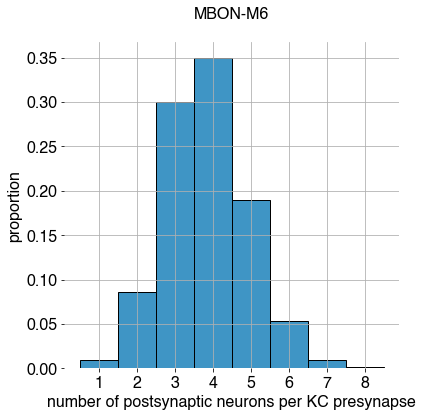

In [38]:
allsynconn_df = []
literaturetargetmbon = papermbons_df['literature'][0]
fname = "data/allsynconn_" + literaturetargetmbon + ".pkl"
pkllist = pickle.load(open(fname,"rb"))
allsynconn_df = pkllist[0]
plot_kcoutputnumbers(literaturetargetmbon, allsynconn_df, color = glob_colors[literaturetargetmbon])

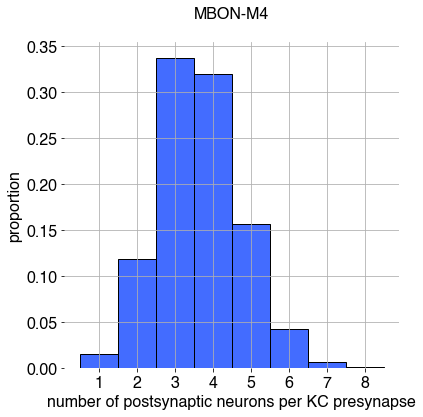

In [39]:
allsynconn_df = []
literaturetargetmbon = papermbons_df['literature'][1]
fname = "data/allsynconn_" + literaturetargetmbon + ".pkl"
pkllist = pickle.load(open(fname,"rb"))
allsynconn_df = pkllist[0]
plot_kcoutputnumbers(literaturetargetmbon, allsynconn_df, color = glob_colors[literaturetargetmbon])

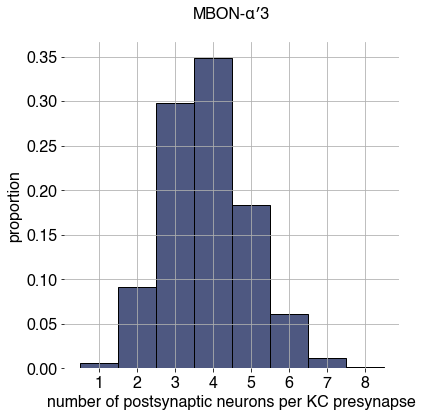

In [40]:
allsynconn_df = []
literaturetargetmbon = papermbons_df['literature'][2]
fname = "data/allsynconn_" + literaturetargetmbon + ".pkl"
pkllist = pickle.load(open(fname,"rb"))
allsynconn_df = pkllist[0]
plot_kcoutputnumbers(literaturetargetmbon, allsynconn_df, color = glob_colors[literaturetargetmbon])

In [41]:
allmbonspecific_df = allmbonspecific_df.sort_values(by=['targetname'], ascending=True)
allmbonspecific_df = allmbonspecific_df.reset_index()
allmbonspecific_df.head()

,index,targetname,onlytargetmbon,with1MBONxx,with2ormoreMBONxx,overallsynapticsites
0,1,MBON-M4,10139,3130,246,13515
1,0,MBON-M6,21142,5270,424,26836
2,2,MBON-α′3,3620,2583,89,6292


In [42]:
allnorm_mbonspecific_df = allnorm_mbonspecific_df.sort_values(by=['targetname'], ascending=True)
allnorm_mbonspecific_df = allnorm_mbonspecific_df.reset_index()
allnorm_mbonspecific_df.head()

,index,targetname,onlytargetmbon,with1MBONxx,with2ormoreMBONxx,overallsynapticsites
0,1,MBON-M4,0.750203,0.231595,0.018202,1.0
1,0,MBON-M6,0.787822,0.196378,0.015800,1.0
2,2,MBON-α′3,0.575334,0.410521,0.014145,1.0


In [43]:
synapsecount_cobodyids_df = synapsecount_cobodyids_df[['target_MBON', 'co_bodyid_type', 'synapticsite_count']]
synapsecount_cobodyids_df

,target_MBON,co_bodyid_type,synapticsite_count
0,MBON-M6,5-HTPMPD01,0.0
1,MBON-M6,ALBN1,0.0
2,MBON-M6,ALIN1,0.0
3,MBON-M6,AOTU008_a,0.0
4,MBON-M6,AOTU019,1.0
...,...,...,...
688,MBON-α′3,TuBu10,0.0
689,MBON-α′3,VES079,0.0
690,MBON-α′3,WEDPN4,0.0
691,MBON-α′3,mAL6,5.0


In [44]:
np.unique(synapsecount_cobodyids_df.target_MBON)

array(['MBON-M4', 'MBON-M6', 'MBON-α′3'], dtype=object)

In [45]:
np.unique(synapsecount_cobodyids_df.co_bodyid_type)

array(['5-HTPMPD01', 'ALBN1', 'ALIN1', 'AOTU008_a', 'AOTU019', 'AOTU020',
       'AOTU021', 'AOTU022', 'AOTU030', 'AOTU031', 'APL', 'ATL005',
       'ATL007', 'ATL035', 'AVLP477', 'AVLP562', 'AVLP563', 'CL021',
       'CL123', 'CL129', 'CL199', 'CL205', 'CL247', 'CL261', 'CL265',
       'CL326', 'CL336', 'CL337', 'CRE001', 'CRE004', 'CRE005', 'CRE008',
       'CRE009', 'CRE011', 'CRE012', 'CRE021', 'CRE022', 'CRE023',
       'CRE024', 'CRE025', 'CRE026', 'CRE027', 'CRE028', 'CRE029_a',
       'CRE029_b', 'CRE029_c', 'CRE030_a', 'CRE030_b', 'CRE031', 'CRE032',
       'CRE035', 'CRE036', 'CRE037', 'CRE038', 'CRE039', 'CRE040',
       'CRE041', 'CRE042', 'CRE043_a', 'CRE043_b', 'CRE043_c', 'CRE043_d',
       'CRE044', 'CRE045', 'CRE046', 'CRE047', 'CRE048', 'CRE049',
       'CRE050', 'CRE051', 'CRE054', 'CRE055', 'CRE058', 'CRE059',
       'CRE060', 'CRE061', 'CRE062', 'CRE064', 'CRE065', 'CRE066',
       'CRE067', 'CRE068', 'CRE070', 'CRE072', 'CRE074', 'CRE075',
       'CRE076', 'CRE077

In [46]:
# synapsecount_cobodyids_df[synapsecount_cobodyids_df.target_MBON.str.contains('MBON-M6') & synapsecount_cobodyids_df.co_bodyid_type.str.contains('MBON')]

In [47]:
#merge some neuron types..
mergedsynapsecount_cobodyids_df = synapsecount_cobodyids_df.copy()
mergedsynapsecount_cobodyids_df['co_bodyid_type'] = mergedsynapsecount_cobodyids_df['co_bodyid_type'].str.replace(r'^PPL.*', 'PPL1', regex=True)
mergedsynapsecount_cobodyids_df['co_bodyid_type'] = mergedsynapsecount_cobodyids_df['co_bodyid_type'].str.replace(r'^PAM.*', 'PAM', regex=True)
mergedsynapsecount_cobodyids_df['co_bodyid_type'] = mergedsynapsecount_cobodyids_df['co_bodyid_type'].str.replace(r'^MBON(?!-).*', 'other MBON', regex=True)

In [48]:
np.unique(list(set(mergedsynapsecount_cobodyids_df['co_bodyid_type']) - set(synapsecount_cobodyids_df['co_bodyid_type'])))

array(['PAM', 'PPL1', 'other MBON'], dtype='<U10')

In [49]:
np.unique(list(set(synapsecount_cobodyids_df['co_bodyid_type']) - set(mergedsynapsecount_cobodyids_df['co_bodyid_type'])))

array(['MBON02', 'MBON04', 'MBON05', 'MBON06', 'MBON07', 'MBON09',
       'MBON10', 'MBON11', 'MBON12', 'MBON13', 'MBON14', 'MBON15',
       'MBON15-like', 'MBON17-like', 'MBON18', 'MBON19', 'MBON20',
       'MBON21', 'MBON22', 'MBON23', 'MBON24', 'MBON25', 'MBON26',
       'MBON27', 'MBON28', 'MBON29', 'MBON30', 'MBON31', 'MBON32',
       'MBON33', 'MBON34', 'MBON35', 'PAM01_a', 'PAM01_b', 'PAM02',
       'PAM03', 'PAM04_a', 'PAM04_b', 'PAM05', 'PAM06_a', 'PAM06_b',
       'PAM07', 'PAM08_a', 'PAM08_b', 'PAM08_c', 'PAM08_d', 'PAM08_e',
       'PAM09', 'PAM10', 'PAM11', 'PAM12', 'PAM13', 'PAM14', 'PAM15_a',
       'PAM15_b', 'PPL101', 'PPL102', 'PPL103', 'PPL104', 'PPL105',
       'PPL106', 'PPL108'], dtype='<U11')

In [50]:
# mergedsynapsecount_cobodyids_df[mergedsynapsecount_cobodyids_df.target_MBON.str.contains('MBON-M6') & mergedsynapsecount_cobodyids_df.co_bodyid_type.str.contains('MBON')]

In [51]:
# mergedsynapsecount_cobodyids_df[mergedsynapsecount_cobodyids_df.target_MBON.str.contains('MBON-M6') & mergedsynapsecount_cobodyids_df.co_bodyid_type.str.contains('PPL')]

In [52]:
mergedsynapsecount_cobodyids_df = mergedsynapsecount_cobodyids_df.groupby(['target_MBON', 'co_bodyid_type'], as_index=False)['synapticsite_count'].sum()

In [53]:
# mergedsynapsecount_cobodyids_df[mergedsynapsecount_cobodyids_df.target_MBON.str.contains('MBON-M6') & mergedsynapsecount_cobodyids_df.co_bodyid_type.str.contains('MBON')]

In [54]:
#reshape dataframe so we have co_bodyid by specific mbon type, the values would be counts where they cooccur on the post-synaptic site..
cobodyid_by_mbontype_df = mergedsynapsecount_cobodyids_df.pivot(index = 'co_bodyid_type', columns='target_MBON',values='synapticsite_count')
cobodyid_by_mbontype_df = cobodyid_by_mbontype_df.reset_index()
cobodyid_by_mbontype_df = cobodyid_by_mbontype_df.set_index('co_bodyid_type')
cobodyid_by_mbontype_df

target_MBON,MBON-M4,MBON-M6,MBON-α′3
co_bodyid_type,,,
5-HTPMPD01,0.0,0.0,0.0
ALBN1,NaN,0.0,NaN
ALIN1,8.0,0.0,0.0
AOTU008_a,0.0,0.0,0.0
AOTU019,NaN,1.0,NaN
...,...,...,...
mALB1,0.0,0.0,0.0
mALD2,NaN,0.0,NaN
mALD3,NaN,0.0,NaN


In [55]:
sorted_cobodyid_bymbontype_df = cobodyid_by_mbontype_df.sort_values(by=['MBON-M6'], ascending=False)
sorted_cobodyid_bymbontype_df
# sorted_cobodyid_bymbontype_df.to_csv('data/sorted_cobodyid_bymbontype.csv', index=True)

target_MBON,MBON-M4,MBON-M6,MBON-α′3
co_bodyid_type,,,
KCg-m,8.0,34523.0,7.0
MBON-M6,170.0,26847.0,0.0
PAM,10651.0,15783.0,0.0
APL,1149.0,6695.0,1494.0
other MBON,3459.0,5963.0,2765.0
...,...,...,...
FB5D,NaN,0.0,NaN
FB6U,NaN,0.0,NaN
KCab-m,0.0,0.0,0.0


In [56]:
normcobodyid_by_mbontype_df = cobodyid_by_mbontype_df.copy()
cols = ['MBON-M4', 'MBON-M6', 'MBON-α′3']
normcobodyid_by_mbontype_df[cols] = 100*normcobodyid_by_mbontype_df[cols] / normcobodyid_by_mbontype_df[cols].sum()

In [57]:
normcobodyid_by_mbontype_df

target_MBON,MBON-M4,MBON-M6,MBON-α′3
co_bodyid_type,,,
5-HTPMPD01,0.000000,0.000000,0.000000
ALBN1,NaN,0.000000,NaN
ALIN1,0.016229,0.000000,0.000000
AOTU008_a,0.000000,0.000000,0.000000
AOTU019,NaN,0.000972,NaN
...,...,...,...
mALB1,0.000000,0.000000,0.000000
mALD2,NaN,0.000000,NaN
mALD3,NaN,0.000000,NaN


In [58]:
normcobodyid_by_mbontype_df[normcobodyid_by_mbontype_df.index == 'PPL1']

target_MBON,MBON-M4,MBON-M6,MBON-α′3
co_bodyid_type,,,
PPL1,0.022315,0.006805,7.248771


In [59]:
# normcobodyid_by_mbontype_df.to_csv('data/normcobodyid_by_mbontype_df.csv', index=True)

In [60]:
normcobodyid_by_mbontype_df['MBON-M4'].sum()

100.0

In [61]:
top_mbonm4 = normcobodyid_by_mbontype_df.sort_values(by=['MBON-M4'], ascending=False)
top_mbonm6 = normcobodyid_by_mbontype_df.sort_values(by=['MBON-M6'], ascending=False)
top_mbonα3 = normcobodyid_by_mbontype_df.sort_values(by=['MBON-α′3'], ascending=False)

In [62]:
topneurontypes = reduce(np.union1d, (top_mbonm4.index[0:7].values, top_mbonm6.index[0:7].values, 
                    top_mbonα3.index[0:7].values))

In [63]:
topneurontypes

array(['APL', 'DPM', "KCa'b'-ap1", "KCa'b'-ap2", "KCa'b'-m", 'KCg-d',
       'KCg-m', 'MBON-M4', 'MBON-M6', 'MBON-α′3', 'PAM', 'PPL1',
       'other MBON'], dtype=object)

In [64]:
topneurontypes_dict = dict(zip(topneurontypes, topneurontypes))

In [65]:
topneurontypes_dict

{'APL': 'APL',
 'DPM': 'DPM',
 "KCa'b'-ap1": "KCa'b'-ap1",
 "KCa'b'-ap2": "KCa'b'-ap2",
 "KCa'b'-m": "KCa'b'-m",
 'KCg-d': 'KCg-d',
 'KCg-m': 'KCg-m',
 'MBON-M4': 'MBON-M4',
 'MBON-M6': 'MBON-M6',
 'MBON-α′3': 'MBON-α′3',
 'PAM': 'PAM',
 'PPL1': 'PPL1',
 'other MBON': 'other MBON'}

In [66]:
normcobodyid_by_mbontype_df.index = normcobodyid_by_mbontype_df.index.map(lambda x: topneurontypes_dict.get(x, 'Others'))

In [67]:
normcobodyid_by_mbontype_df

target_MBON,MBON-M4,MBON-M6,MBON-α′3
co_bodyid_type,,,
Others,0.000000,0.000000,0.000000
Others,NaN,0.000000,NaN
Others,0.016229,0.000000,0.000000
Others,0.000000,0.000000,0.000000
Others,NaN,0.000972,NaN
...,...,...,...
Others,0.000000,0.000000,0.000000
Others,NaN,0.000000,NaN
Others,NaN,0.000000,NaN


In [68]:
sorted_df = normcobodyid_by_mbontype_df.sort_values('MBON-M4', ascending = False)
sorted_df

target_MBON,MBON-M4,MBON-M6,MBON-α′3
co_bodyid_type,,,
MBON-M4,27.737093,0.165273,0.000000
PAM,21.606654,15.344157,0.000000
KCa'b'-ap2,16.648747,1.771340,16.707282
KCa'b'-m,14.685059,0.246938,10.387840
other MBON,7.016939,5.797200,11.420429
...,...,...,...
Others,NaN,0.000000,NaN
Others,NaN,0.000000,NaN
Others,NaN,0.000000,NaN


In [69]:
sorted_df = sorted_df[sorted_df.index != 'Others']

In [70]:
sorted_df = sorted_df.append(pd.Series(100-sorted_df.sum(), name='others'))
sorted_df

target_MBON,MBON-M4,MBON-M6,MBON-α′3
co_bodyid_type,,,
MBON-M4,27.737093,0.165273,0.000000
PAM,21.606654,15.344157,0.000000
KCa'b'-ap2,16.648747,1.771340,16.707282
KCa'b'-m,14.685059,0.246938,10.387840
other MBON,7.016939,5.797200,11.420429
KCa'b'-ap1,6.268384,2.931169,8.909174
DPM,3.059134,3.036166,7.542026
APL,2.330865,6.508847,6.170749
MBON-M6,0.344863,26.100525,0.000000


In [71]:
coneuronssorted_df = sorted_df.reindex(["MBON-M4", "MBON-M6", "MBON-α′3", "other MBON",
                                        "PAM", "PPL1",
                                        "KCa'b'-ap2", "KCa'b'-m", "KCa'b'-ap1",
                                        "KCg-m", "KCg-d",
                                        "DPM", "APL",
                                        "others"
                                       ])

In [72]:
coneuronssorted_df

target_MBON,MBON-M4,MBON-M6,MBON-α′3
co_bodyid_type,,,
MBON-M4,27.737093,0.165273,0.000000
MBON-M6,0.344863,26.100525,0.000000
MBON-α′3,0.000000,0.000000,30.742225
other MBON,7.016939,5.797200,11.420429
PAM,21.606654,15.344157,0.000000
PPL1,0.022315,0.006805,7.248771
KCa'b'-ap2,16.648747,1.771340,16.707282
KCa'b'-m,14.685059,0.246938,10.387840
KCa'b'-ap1,6.268384,2.931169,8.909174


In [73]:
coneuronssorted_df['MBON-M4'].sum()

100.0

In [74]:
glob_colors

{nan: (0.18823529411764706, 0.0784313725490196, 0.01568627450980392),
 'DPM': (0.5607843137254902, 0.8549019607843137, 0.01568627450980392),
 'APL': (0.3607843137254902, 0.6549019607843137, 0.0),
 'KCg-m': (0.9568627450980393, 0.7254901960784313, 0.35294117647058826),
 'PPL1': (0.8352941176470589, 0.3686274509803922, 0.22745098039215686),
 "KCa'b'-m": (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
 "KCa'b'-ap1": (0.9215686274509803, 0.7490196078431373, 0.023529411764705882),
 "KCa'b'-ap2": (0.9725490196078431, 0.9411764705882353, 0.592156862745098),
 'KCg-d': (0.9333333333333333, 0.25882352941176473, 0.26666666666666666),
 'PAM': (0.6862745098039216, 0.3803921568627451, 0.1450980392156863),
 'MBON-M6': (0.0, 0.4470588235294118, 0.6980392156862745),
 'MBON-M4': (0.0196078431372549, 0.23529411764705882, 1.0),
 'other MBON': (0.6392156862745098, 0.8, 0.9137254901960784),
 'others': (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
 'MBON-α′3': (0.07450980392156

In [75]:
sns.set(style='white')

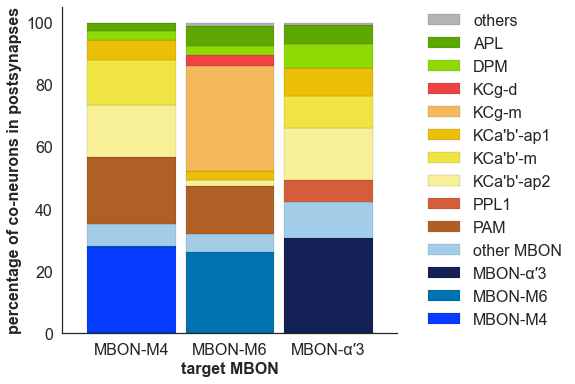

In [76]:
fig = plt.figure(figsize=(6, 6))
gs_main = gridspec.GridSpec(1, 1)
gs_main.update(wspace=0, hspace=0)

#set up the legend..
gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax = fig.add_subplot(gs[0])
ax = coneuronssorted_df.T.plot(kind='bar', stacked=True, ax = ax, color = glob_colors,
                     linewidth=0.1, width = 0.9, edgecolor='black')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left', 
          bbox_to_anchor=(1.05, 0.5),prop={'size': label_fontsize},frameon=False)

ax.tick_params(axis='both', which='major', labelsize=label_fontsize)
# plt.box(False)
# ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=0)
ax.set_xlabel('target MBON',fontsize=label_fontsize, weight = 'bold')
ax.set_ylabel('percentage of co-neurons in postsynapses',fontsize=label_fontsize, weight = 'bold')
plt.savefig('figures/mbon_parsing_specificity.png', dpi=300, bbox_inches='tight')

# Figure (b) location:

[Figure(b)location](https://hemibrain-dot-neuroglancer-demo.appspot.com/#!%7B%22dimensions%22:%7B%22x%22:%5B8e-9%2C%22m%22%5D%2C%22y%22:%5B8e-9%2C%22m%22%5D%2C%22z%22:%5B8e-9%2C%22m%22%5D%7D%2C%22position%22:%5B24384%2C28006%2C18708%5D%2C%22crossSectionScale%22:0.7247123281127775%2C%22crossSectionDepth%22:-37.62185354999912%2C%22projectionScale%22:29395.943688541935%2C%22layers%22:%5B%7B%22type%22:%22image%22%2C%22source%22:%22precomputed://gs://neuroglancer-janelia-flyem-hemibrain/emdata/clahe_yz/jpeg%22%2C%22tab%22:%22source%22%2C%22opacity%22:1%2C%22blend%22:%22additive%22%2C%22volumeRendering%22:true%2C%22name%22:%22emdata%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%7B%22url%22:%22precomputed://gs://neuroglancer-janelia-flyem-hemibrain/v1.2/segmentation%22%2C%22subsources%22:%7B%22default%22:true%2C%22properties%22:true%2C%22mesh%22:true%7D%2C%22enableDefaultSubsources%22:false%7D%2C%22tab%22:%22segments%22%2C%22objectAlpha%22:0.3%2C%22segments%22:%5B%221233436396%22%2C%22425790257%22%2C%22508918609%22%2C%22548549395%22%2C%22579592279%22%2C%225812979271%22%2C%225812981068%22%2C%225812982088%22%2C%22612738462%22%5D%2C%22segmentQuery%22:%22508918609%2C%201233436396%2C%20548549395%2C%205812981068%2C%205812979271%2C%20579592279%2C%205812982088%2C%20425790257%2C%20612738462%22%2C%22colorSeed%22:1736096302%2C%22name%22:%22segmentation%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%7B%22url%22:%22precomputed://gs://neuroglancer-janelia-flyem-hemibrain/v1.2/rois%22%2C%22subsources%22:%7B%22default%22:true%2C%22properties%22:true%2C%22mesh%22:true%7D%2C%22enableDefaultSubsources%22:false%7D%2C%22pick%22:false%2C%22tab%22:%22segments%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22objectAlpha%22:0.8%2C%22ignoreNullVisibleSet%22:false%2C%22meshSilhouetteRendering%22:3%2C%22colorSeed%22:2685294016%2C%22name%22:%22roi%22%2C%22visible%22:false%7D%2C%7B%22type%22:%22annotation%22%2C%22source%22:%22precomputed://gs://neuroglancer-janelia-flyem-hemibrain/v1.2/synapses%22%2C%22tab%22:%22annotations%22%2C%22ignoreNullSegmentFilter%22:false%2C%22shader%22:%22#uicontrol%20vec3%20preColor%20color%28default=%5C%22red%5C%22%29%5Cn#uicontrol%20vec3%20postColor%20color%28default=%5C%22blue%5C%22%29%5Cn#uicontrol%20float%20preConfidence%20slider%28min=0%2C%20max=1%2C%20default=0%29%5Cn#uicontrol%20float%20postConfidence%20slider%28min=0%2C%20max=1%2C%20default=0%29%5Cn%5Cnvoid%20main%28%29%20%7B%5Cn%20%20setColor%28defaultColor%28%29%29%3B%5Cn%20%20setEndpointMarkerColor%28%5Cn%20%20%20%20vec4%28preColor%2C%200.5%29%2C%5Cn%20%20%20%20vec4%28postColor%2C%200.5%29%29%3B%5Cn%20%20setEndpointMarkerSize%282.0%2C%202.0%29%3B%5Cn%20%20setLineWidth%282.0%29%3B%5Cn%20%20if%20%28prop_pre_synaptic_confidence%28%29%3C%20preConfidence%20%7C%7C%5Cn%20%20%20%20%20%20prop_post_synaptic_confidence%28%29%3C%20postConfidence%29%20discard%3B%5Cn%7D%5Cn%22%2C%22linkedSegmentationLayer%22:%7B%22pre_synaptic_cell%22:%22segmentation%22%7D%2C%22filterBySegmentation%22:%5B%22post_synaptic_cell%22%2C%22pre_synaptic_cell%22%5D%2C%22name%22:%22synapse%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%7B%22url%22:%22precomputed://gs://neuroglancer-janelia-flyem-hemibrain/v1.2/mito-classes%22%2C%22subsources%22:%7B%22default%22:true%2C%22properties%22:true%2C%22mesh%22:true%7D%2C%22enableDefaultSubsources%22:false%7D%2C%22pick%22:false%2C%22tab%22:%22segments%22%2C%22segmentColors%22:%7B%224%22:%22#000000%22%7D%2C%22name%22:%22mito-classes%22%2C%22visible%22:false%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%7B%22url%22:%22precomputed://gs://neuroglancer-janelia-flyem-hemibrain/mask_normalized_round6%22%2C%22subsources%22:%7B%22default%22:true%2C%22properties%22:true%7D%2C%22enableDefaultSubsources%22:false%7D%2C%22pick%22:false%2C%22tab%22:%22segments%22%2C%22selectedAlpha%22:0.53%2C%22segmentColors%22:%7B%227%22:%22#000000%22%7D%2C%22name%22:%22mask%22%2C%22visible%22:false%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%7B%22url%22:%22precomputed://gs://neuroglancer-janelia-flyem-hemibrain/v1.2/mito-objects-grouped%22%2C%22subsources%22:%7B%22default%22:true%2C%22mesh%22:true%7D%2C%22enableDefaultSubsources%22:false%7D%2C%22pick%22:false%2C%22tab%22:%22segments%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22linkedSegmentationGroup%22:%22segmentation%22%2C%22name%22:%22mito-grouped%22%2C%22visible%22:false%7D%5D%2C%22showAxisLines%22:false%2C%22showSlices%22:false%2C%22selectedLayer%22:%7B%22visible%22:true%2C%22layer%22:%22segmentation%22%7D%2C%22layout%22:%224panel%22%2C%22selection%22:%7B%7D%7D)

# Figure (c) location:

[Figure(c)location](https://hemibrain-dot-neuroglancer-demo.appspot.com/#!%7B%22dimensions%22:%7B%22x%22:%5B8e-9%2C%22m%22%5D%2C%22y%22:%5B8e-9%2C%22m%22%5D%2C%22z%22:%5B8e-9%2C%22m%22%5D%7D%2C%22position%22:%5B21481.5%2C29532.41796875%2C18772.5%5D%2C%22crossSectionScale%22:0.7247123281127775%2C%22crossSectionDepth%22:-37.62185354999912%2C%22projectionScale%22:29395.943688541935%2C%22layers%22:%5B%7B%22type%22:%22image%22%2C%22source%22:%22precomputed://gs://neuroglancer-janelia-flyem-hemibrain/emdata/clahe_yz/jpeg%22%2C%22tab%22:%22source%22%2C%22opacity%22:1%2C%22blend%22:%22additive%22%2C%22volumeRendering%22:true%2C%22name%22:%22emdata%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%7B%22url%22:%22precomputed://gs://neuroglancer-janelia-flyem-hemibrain/v1.2/segmentation%22%2C%22subsources%22:%7B%22default%22:true%2C%22properties%22:true%2C%22mesh%22:true%7D%2C%22enableDefaultSubsources%22:false%7D%2C%22tab%22:%22segments%22%2C%22objectAlpha%22:0.3%2C%22segments%22:%5B%221016835041%22%2C%221048215779%22%2C%225813078179%22%2C%22612738462%22%5D%2C%22segmentQuery%22:%225813078179%2C%201016835041%2C%20424789697%2C%201048215779%2C%20612738462%22%2C%22colorSeed%22:3115870074%2C%22name%22:%22segmentation%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%7B%22url%22:%22precomputed://gs://neuroglancer-janelia-flyem-hemibrain/v1.2/rois%22%2C%22subsources%22:%7B%22default%22:true%2C%22properties%22:true%2C%22mesh%22:true%7D%2C%22enableDefaultSubsources%22:false%7D%2C%22pick%22:false%2C%22tab%22:%22segments%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22objectAlpha%22:0.8%2C%22ignoreNullVisibleSet%22:false%2C%22meshSilhouetteRendering%22:3%2C%22colorSeed%22:2685294016%2C%22name%22:%22roi%22%2C%22visible%22:false%7D%2C%7B%22type%22:%22annotation%22%2C%22source%22:%22precomputed://gs://neuroglancer-janelia-flyem-hemibrain/v1.2/synapses%22%2C%22tab%22:%22annotations%22%2C%22ignoreNullSegmentFilter%22:false%2C%22shader%22:%22#uicontrol%20vec3%20preColor%20color%28default=%5C%22red%5C%22%29%5Cn#uicontrol%20vec3%20postColor%20color%28default=%5C%22blue%5C%22%29%5Cn#uicontrol%20float%20preConfidence%20slider%28min=0%2C%20max=1%2C%20default=0%29%5Cn#uicontrol%20float%20postConfidence%20slider%28min=0%2C%20max=1%2C%20default=0%29%5Cn%5Cnvoid%20main%28%29%20%7B%5Cn%20%20setColor%28defaultColor%28%29%29%3B%5Cn%20%20setEndpointMarkerColor%28%5Cn%20%20%20%20vec4%28preColor%2C%200.5%29%2C%5Cn%20%20%20%20vec4%28postColor%2C%200.5%29%29%3B%5Cn%20%20setEndpointMarkerSize%282.0%2C%202.0%29%3B%5Cn%20%20setLineWidth%282.0%29%3B%5Cn%20%20if%20%28prop_pre_synaptic_confidence%28%29%3C%20preConfidence%20%7C%7C%5Cn%20%20%20%20%20%20prop_post_synaptic_confidence%28%29%3C%20postConfidence%29%20discard%3B%5Cn%7D%5Cn%22%2C%22linkedSegmentationLayer%22:%7B%22pre_synaptic_cell%22:%22segmentation%22%7D%2C%22filterBySegmentation%22:%5B%22post_synaptic_cell%22%2C%22pre_synaptic_cell%22%5D%2C%22name%22:%22synapse%22%2C%22visible%22:false%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%7B%22url%22:%22precomputed://gs://neuroglancer-janelia-flyem-hemibrain/v1.2/mito-classes%22%2C%22subsources%22:%7B%22default%22:true%2C%22properties%22:true%2C%22mesh%22:true%7D%2C%22enableDefaultSubsources%22:false%7D%2C%22pick%22:false%2C%22tab%22:%22segments%22%2C%22segmentColors%22:%7B%224%22:%22#000000%22%7D%2C%22name%22:%22mito-classes%22%2C%22visible%22:false%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%7B%22url%22:%22precomputed://gs://neuroglancer-janelia-flyem-hemibrain/mask_normalized_round6%22%2C%22subsources%22:%7B%22default%22:true%2C%22properties%22:true%7D%2C%22enableDefaultSubsources%22:false%7D%2C%22pick%22:false%2C%22tab%22:%22segments%22%2C%22selectedAlpha%22:0.53%2C%22segmentColors%22:%7B%227%22:%22#000000%22%7D%2C%22name%22:%22mask%22%2C%22visible%22:false%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%7B%22url%22:%22precomputed://gs://neuroglancer-janelia-flyem-hemibrain/v1.2/mito-objects-grouped%22%2C%22subsources%22:%7B%22default%22:true%2C%22mesh%22:true%7D%2C%22enableDefaultSubsources%22:false%7D%2C%22pick%22:false%2C%22tab%22:%22segments%22%2C%22selectedAlpha%22:0%2C%22saturation%22:0%2C%22linkedSegmentationGroup%22:%22segmentation%22%2C%22name%22:%22mito-grouped%22%2C%22visible%22:false%7D%5D%2C%22showAxisLines%22:false%2C%22showSlices%22:false%2C%22selectedLayer%22:%7B%22visible%22:true%2C%22layer%22:%22segmentation%22%7D%2C%22layout%22:%224panel%22%2C%22selection%22:%7B%7D%7D)

In [93]:
def flatten(list_arr):
    rt = []
    for i in list_arr:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

In [94]:
neuprintmbonList = papermbons_df['em'].values
neuprintmbonList = flatten(neuprintmbonList)

In [95]:
mbonneurons_df, roi_counts_df = neu.fetch_neurons(NC(status='Traced',type=neuprintmbonList,regex=True)) #get some traced MBON neurons..

In [99]:
# get the neurons of the MBON type
plotmbon_list = np.sort(mbonneurons_df['bodyId'].unique())
plotmbon_list

array([ 487925037,  612371421,  612738462,  673366098,  673509195,
       5812981264])

In [97]:
mbon_skel = neu.fetch_skeletons(plotmbon_list, heal=1000, max_threads=30)

Fetching:   0%|          | 0/6 [00:00<?, ?it/s]

In [98]:
mbon_skel

,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,navis.TreeNeuron,MBON17(a'3m)_R,5812981264,11159,4171,1098,1121,4.079417e+05,8950,8 nanometer
1,navis.TreeNeuron,MBON16(a'3ap)_R,673366098,12349,6535,1375,1411,5.230673e+05,4610,8 nanometer
...,...,...,...,...,...,...,...,...,...,...
4,navis.TreeNeuron,MBON01(y5B'2a)_L,673509195,57132,31449,7232,7417,2.168119e+06,14772,8 nanometer
5,navis.TreeNeuron,MBON01(y5B'2a)_R,612371421,58425,34752,7002,7170,2.293624e+06,23124,8 nanometer


In [119]:
figwidth_size = 20
figheigth_size = 20

In [187]:
#fetch mesh for mushroombody..
mb_gammalobe = neu.fetch_roi('gL(R)')
mb_gammalobe.color = (.9, .9, .9, .75) #,(.9, .9, .9, .05)
mb_alphalobe = neu.fetch_roi('aL(R)')
mb_alphalobe.color = (.9, .9, .9, .75) #,(.9, .9, .9, .05)

In [173]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

In [174]:
# Generate 2D outlines for roi
def get_outlines(roi):
    roi2d = np.array(roi.to_2d(alpha = 2,view = 'xz'))
    roi_outlines = np.append(roi2d, np.repeat(roi.center[2], roi2d.shape[0]).reshape(roi2d.shape[0], 1), axis=1)
    return roi_outlines

In [175]:
gammalobe_outlines = get_outlines(mb_gammalobe)
alphalobe_outlines = get_outlines(mb_alphalobe)

/var/folders/n2/vs914nyj7g5__mmfqkwqf9s80000gn/T/ipykernel_1295/381520463.py:3: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  roi2d = np.array(roi.to_2d(alpha = 2,view = 'xz'))


In [176]:
# #fetch mesh for al..
# al_R = neu.fetch_roi('AL(R)')
# fig, ax = navis.plot2d(al_R, method='2d', view=('x','-z'))
# plt.show()

In [ ]:
array([ 487925037,  612371421,  612738462,  673366098,  673509195,
       5812981264])

WARNING - 2022-08-17 19:53:05,568 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
WARNING - 2022-08-17 19:53:05,707 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


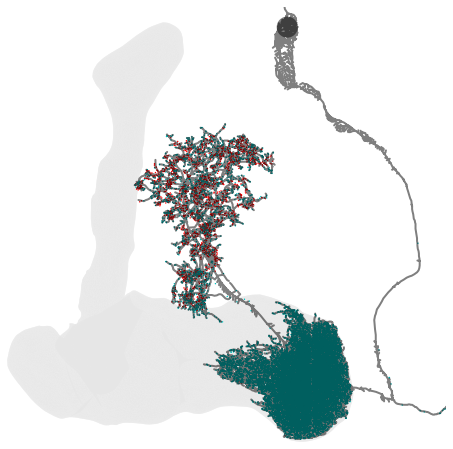

In [190]:
# Make a 2d plot
mbon_skel_plot = mbon_skel[np.in1d(mbon_skel.id, [612371421])]
fig, ax = navis.plot2d([mb_alphalobe, mb_gammalobe],method='2d', view=('x','-z'))
navis.plot2d(mbon_skel_plot, ax = ax, method='2d', view=('x','-z'),
             connectors=True, color = 'black', linewidth=2, alpha = 0.5)
fig.savefig('figures/mbon_example_em.png',format='png', dpi=300, transparent=True, bbox_inches='tight')

In [189]:
# gl_mb = Poly3DCollection([gammalobe_outlines[:, [0, 2, 1]]], linewidth=1.5, 
#                         facecolor=(0, 0, 0, 0), edgecolor=(0, 0, 0, 1), linestyle='-')
# ax.scatter(gammalobe_outlines[:,0],gammalobe_outlines[:,2],gammalobe_outlines[:,1], alpha = 0)
# ax.add_collection3d(gl_mb)


# al_mb = Poly3DCollection([alphalobe_outlines[:, [0, 2, 1]]], linewidth=1.5, 
#                         facecolor=(0, 0, 0, 0), edgecolor=(0, 0, 0, 1), linestyle='-')
# ax.scatter(alphalobe_outlines[:,0],alphalobe_outlines[:,2],alphalobe_outlines[:,1], alpha = 0)
# ax.add_collection3d(al_mb)

# mbon_skel_plot = mbon_skel[np.in1d(mbon_skel.id, [487925037])]
# # navis.plot2d(mb,ax=ax,method='3d', lw=.8)
# navis.plot2d(mbon_skel_plot, method='3d', ax = ax, connectors=False, color = 'b', linewidth=1, alpha = 0.5)


# # Rotate to frontal view
# ax.elev = elev
# ax.azim = azim
# ax.dist = dist